## Семинар 3 "Определение ключевых точек лица"

ФИО: Дегтярев Роман Олегович

# Подготовительная задача 1

Сделать из линейной регрессии nn.sequental двухслойную сеть

In [8]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
#Parameters:
_LR = 0.01
_BATCH_SIZE = 32
_EPOCH = 20
_EPS=1.00000e-02
_RAND_STATE = 42

In [ ]:
#Load MNIST
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('.', train=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
#network architecture 
class network_sigmoid(nn.Module):

    def __init__(self):
        super(network_sigmoid, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(784, 100),
            nn.Sigmoid()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(100, _BATCH_SIZE),
            nn.Sigmoid()
        )
        self.fc = nn.Linear(_BATCH_SIZE,10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.fc(out)
        return out

In [ ]:
fnn = network_sigmoid()

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fnn.parameters(), lr=_LR)

# Подготовительная задача 2

Используя структуру сети Sequental в pytorch реализовать и обучить классификатор цифр из MNIST
(повторить первый и второй пункты из прошлого задания )

In [ ]:
loss_train = []
for i in range(_EPOCH):
    for j,[image,label] in enumerate(train_loader):
        image = Variable(image)
        label = Variable(label)
        image = image.view(-1, 28*28)
        #print image.size()
        optimizer.zero_grad()
        result = fnn.forward(image)
        loss = loss_func(result,label)
        loss.backward()
        optimizer.step()
        if (loss.data.numpy()[0]<_EPS):
            break
        
        if j % 1000 == 0:
            loss_train.append(loss.data.numpy()[0])
            print(loss)

In [ ]:
#Network with Sigmoid 
plt.plot(np.array(loss_train), label='Train')
plt.ylabel('CrossEntropyLoss')
plt.xlabel('Number of epoch')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
class network_ReLU(nn.Module):

    def __init__(self):
        super(network_ReLU, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(100, _BATCH_SIZE),
            nn.ReLU()
        )
        self.fc = nn.Linear(_BATCH_SIZE,10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.fc(out)
        return out

In [ ]:
snn = network_ReLU()

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(snn.parameters(), lr=_LR)

In [ ]:
loss_train = []
for i in range(_EPOCH):
    for j,[image,label] in enumerate(train_loader):
        image = Variable(image)
        label = Variable(label)
        image = image.view(-1, 28*28)
        #print image.size()
        optimizer.zero_grad()
        result = snn.forward(image)
        loss = loss_func(result,label)
        loss.backward()
        optimizer.step()
        if (loss.data.numpy()[0]<_EPS):
            break
        
        if j % 1000 == 0:
            loss_train.append(loss.data.numpy()[0])
            #print(loss)

In [ ]:
#Network with ReLU
plt.plot(np.array(loss_train), label='Train')
plt.ylabel('CrossEntropyLoss')
plt.xlabel('Number of epoch')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
#Для ReLU сошлось побыстрее

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Попробуйте сети глубины 1 и 2 и разные активации (ELU, RELU и sigmoid).

Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[  7.  41.]
 [  8.  51.]
 [ 10.  60.]
 [ 13.  70.]]
(96, 96)


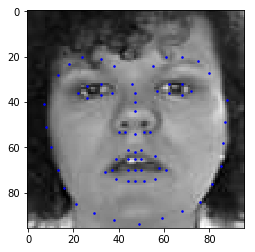

In [1]:
%matplotlib inline
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    print(image.shape)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='b')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),
               landmarks)
plt.show()

In [2]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or tuple): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
 
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        #image = image.transpose((0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [3]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.ix[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.ix[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
train_landmarks_path = 'dataset/train/face_landmarks.csv'
train_path = 'dataset/train/'
test_landmarks_path = 'dataset/test/face_landmarks.csv'
test_path = 'dataset/test'

In [5]:
train = FaceLandmarksDataset(csv_file=train_landmarks_path,
                                           root_dir= train_path, transform=transforms.Compose([
                                               #RandomCrop(90),
                                               ToTensor()
                                           ])
                                           )

for i in range(len(train)):
    sample = train[i]

    print(i, sample['image'].float().size(), sample['landmarks'].float().size())
 
    if i == 3:
        plt.show()

        break

0 torch.Size([96, 96]) torch.Size([68, 2])
1 torch.Size([96, 96]) torch.Size([68, 2])
2 torch.Size([96, 96]) torch.Size([68, 2])
3 torch.Size([96, 96]) torch.Size([68, 2])


In [6]:
dataloader = DataLoader(train, batch_size=40,
                        shuffle=True, num_workers=4)

In [14]:
D_in, H, D_out = 96*96, 330, 136

num_epoch = 10
def predict(model, x_val):
    
    x = Variable(x_val, requires_grad=False)
    output = model.forward(x)
    return output.data.numpy()


model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.Sigmoid(),
          torch.nn.Linear(H, D_out)
        )

loss_fn = torch.nn.MSELoss(size_average=True)

learning_rate = 0.01
error = []
error_train = []
optimizer =  torch.optim.SGD(model.parameters(), lr=learning_rate)
for t in range(num_epoch):
    for T in dataloader:
        X = T['image'].view(T['image'].size(0), -1).float()
        Y = T['landmarks'].view(T['landmarks'].size(0), -1).float()
        x = Variable(X, requires_grad=False)
        y = Variable(Y, requires_grad=False)
        
        y_pred = model.forward(x)

        loss =  loss_fn(y_pred, y)
        error.append(loss.data[0])
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    print ('epoch %d, meanerror %f' % (t,  np.array(error).mean()))
    error_train.append(np.array(error).mean())

epoch 0, meanerror 401.223703
epoch 1, meanerror 209.382010
epoch 2, meanerror 145.427840
epoch 3, meanerror 113.443800
epoch 4, meanerror 94.255335
epoch 5, meanerror 81.462011
epoch 6, meanerror 72.323421
epoch 7, meanerror 65.469903
epoch 8, meanerror 60.146999
epoch 9, meanerror 55.882734


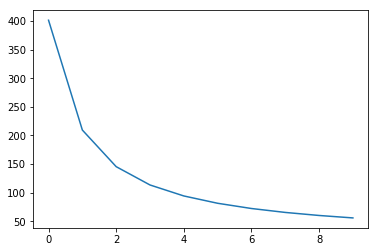

In [16]:
plt.figure()
plt.plot(range(num_epoch), error_train)

In [17]:
test = FaceLandmarksDataset(csv_file=test_landmarks_path,
                                               root_dir=test_path, transform=transforms.Compose([
                                                   #RandomCrop(90),
                                                   ToTensor()
                                               ])
                                               )

In [20]:
import warnings
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv(test_landmarks_path)

#n = 60
#img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)


def plt_test(i):   
    landmarks = landmarks_frame.ix[i, 1:].as_matrix().astype('float')
    landmarks = landmarks.reshape(-1, 2)
    plt.figure()
    a = test[i]['image'].float()
    a = a.view(-1)
    f = predict(model, a)
    f_1 = f[::2]
    f_2 = f[1::2]
    img_name = landmarks_frame.ix[i, 0]
    plt.figure()
    plt.imshow(io.imread(os.path.join(test_path, img_name)), cmap='gray')
    plt.scatter(f_1, f_2, s=10, marker='.', c='b')
    #plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')

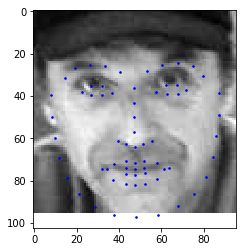

In [21]:
plt_test(5)